In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import time
import os

from IPython.display import display

#1. Upload Excel files

In [2]:
from google.colab import files
uploaded = files.upload()

Saving albums.xlsx to albums.xlsx
Saving albums_evaluation.xlsx to albums_evaluation.xlsx
Saving albums_full.xlsx to albums_full.xlsx
Saving albums_full_evaluation.xlsx to albums_full_evaluation.xlsx
Saving artists.xlsx to artists.xlsx
Saving artists_evaluation.xlsx to artists_evaluation.xlsx
Saving artists_full.xlsx to artists_full.xlsx
Saving artists_full_evaluation.xlsx to artists_full_evaluation.xlsx
Saving tracks.xlsx to tracks.xlsx
Saving tracks_evaluation.xlsx to tracks_evaluation.xlsx
Saving tracks_full.xlsx to tracks_full.xlsx
Saving tracks_full_evaluation.xlsx to tracks_full_evaluation.xlsx


In [3]:
import io

dataframes = {}
for filename, f in uploaded.items():
    # checking if it is an Excel file and an evaluation file
    if '.xlsx' in filename and 'evaluation' in filename:
        dataframes[filename] = pd.read_excel(f, index_col=[0])

# Reordering dataframes
i_1, j_1 = 0, 2
i_2, j_2 = 1, 3
tups = list(dataframes.items())
# Swapping
tups[i_1], tups[j_1] = tups[j_1], tups[i_1]
tups[i_2], tups[j_2] = tups[j_2], tups[i_2]
dataframes = dict(tups)

for filename, dataframe in dataframes.items():
    # display(dataframe.describe())
    # display(dataframe.info())
    print(f"{filename} : {len(dataframe.index)} elements\n")

artists_evaluation.xlsx : 100 elements

artists_full_evaluation.xlsx : 100 elements

albums_evaluation.xlsx : 100 elements

albums_full_evaluation.xlsx : 100 elements

tracks_evaluation.xlsx : 100 elements

tracks_full_evaluation.xlsx : 100 elements



#2. Analysis

### 2.1 Utils

In [4]:
def format_name(name):
    name = name.replace('.xlsx', '').replace('_', ' ').replace('evaluation', '')
    name = name.capitalize()
    return name

In [5]:
def plot_series(filename, series_to_plot, kind='hist'):
    filename = format_name(filename)
    nrows = 2
    ncols = 3

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, constrained_layout=True)
    fig.set_figwidth(10)
    fig.suptitle(filename)

    ax_i = 0
    ax_j = 0

    for s in series_to_plot:
        y_ticks = [i for i in range(0, len(s) + 25, 25)]
        color = None
        name = format_name(s.name)
        if 'Genius' in name:
          color = 'y'
        elif 'Geonames' in name:
          color = 'g'
        elif 'Dbpedia' in name:
          color = 'b'
        
        s.plot(kind=kind, ax=axes[ax_i, ax_j], color=color)
        
        axes[ax_i,ax_j].set_title(name)
        if 'completeness' in name:
          axes[ax_i,ax_j].set_xlabel('Completeness percentage')
          axes[ax_i,ax_j].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
        elif 'download' in name:
          axes[ax_i,ax_j].set_xlabel('Download seconds')
          if 'Dbpedia' in name:
              axes[ax_i,ax_j].set_xticks(range(0, 60, 10))
          elif 'Genius' in name:
              axes[ax_i,ax_j].set_xticks(range(0, 25, 5))
          elif 'Geonames' in name:
              axes[ax_i,ax_j].set_xticks(np.arange(0.0, 0.4, 0.1))

        axes[ax_i,ax_j].set_yticks(y_ticks)

        ax_j += 1
        if ax_j == ncols:
            ax_j = 0
            ax_i += 1
            if ax_i == nrows:
                ax_i = 0
   
    # Saving plot to file
    dir_name = 'plots'
    if os.path.exists(dir_name) == False:
        os.mkdir(dir_name)
    path_to_file = f"{dir_name}/{filename.replace('.xlsx', '_plot.png')}"
    plt.savefig(path_to_file)
    plt.show()
    print("\n")


In [6]:
!pip install xlsxwriter
def save_excel(dataframe, dirname, filename):
    # ATTENTION! xlsxwriter Python library required to customize Excel writing!
    writer = pd.ExcelWriter(os.path.join(dirname, filename))
    dataframe.to_excel(writer, sheet_name=filename)
    # Adjusting columns' width according to length of words
    for column in dataframe:
        column_length = max([len(i) for i in dataframe.keys()]) + 2
        col_idx = dataframe.columns.get_loc(column)
        writer.sheets[filename].set_column(col_idx, col_idx, column_length)
    writer.save()

     |████████████████████████████████| 149 kB 5.0 MB/s 


In [7]:
def generate_partial_summary(filename, series):
    filename = format_name(filename)
    partial_summary = pd.DataFrame(index=[filename])

    for s in series:
        name = format_name(s.name)
        if 'completeness' in name:
            empty_percentage = round(s[s == 0.0].count() * s.count() / 100 / 100, 2)
            not_empty = s[s!=0.0]
            data = {
                f'Empty {name.split()[0]} percentage': empty_percentage,
                f"Mean {name} (without considering empty entries)": not_empty.mean(),
            }
        else:
            data = {
                f"Mean {name}": s.mean()
        }
        dataframe = pd.DataFrame(index=[filename], data=data)
        partial_summary = pd.concat([partial_summary, dataframe], axis=1)
    return partial_summary

In [8]:
def plot_summary(summary, kind='bar'):
    completeness_dataframe = summary.filter(regex="completeness")
    download_time_dataframe = summary.filter(regex="download")
    empty_percentage_dataframe = summary.filter(regex="Empty")

    fig, axes = plt.subplots(nrows=3, ncols=1, constrained_layout=True)
    fig.set_figwidth(10)
    fig.set_figheight(15)

    legend = ['Genius', 'Dbpedia', 'Geonames']
    color = ['y', 'b', 'g']

    completeness_dataframe.plot(kind=kind, ax=axes[0], color=color)
    axes[0].set_title("Mean completeness percentages (without considering empty data)")
    axes[0].set_ylabel('Completeness percentage')
    axes[0].set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
    axes[0].legend(legend)

    download_time_dataframe.plot(kind=kind, ax=axes[1], color=color)
    axes[1].set_title("Mean download times")
    axes[1].set_ylabel('Download seconds')
    axes[1].set_yticks(range(0, 40, 5))
    axes[1].legend(legend)

    empty_percentage_dataframe.plot(kind=kind, ax=axes[2], color=color)
    axes[2].set_title("Empty data percentages")
    axes[2].set_ylabel('Empty percentage')
    axes[2].set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
    axes[2].legend(legend)

    # Saving plots to files
    dirname = 'plots/summary'
    if os.path.exists(dirname) == False:
        os.mkdir(dirname)
        
    path_to_file = f"{dirname}/summary_plots.png"
    plt.savefig(path_to_file)
    plt.show()
    print("\n")

## 2.2 Analysis and summary generation

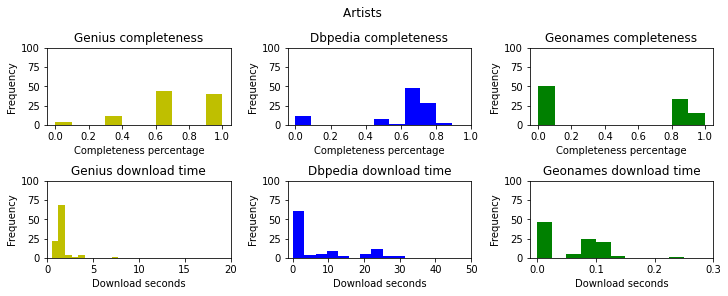

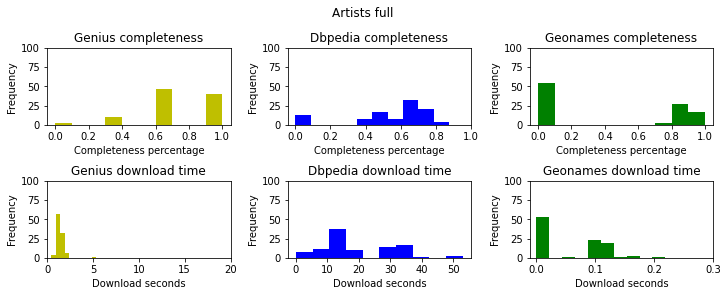

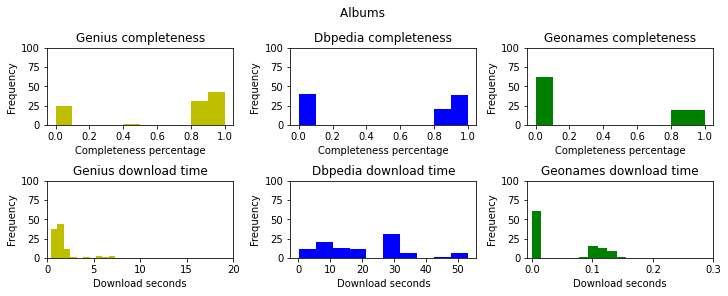

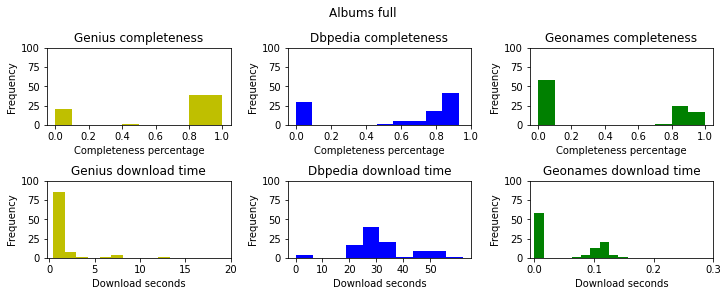

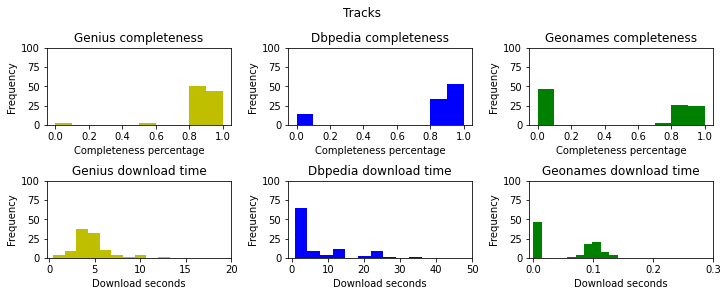

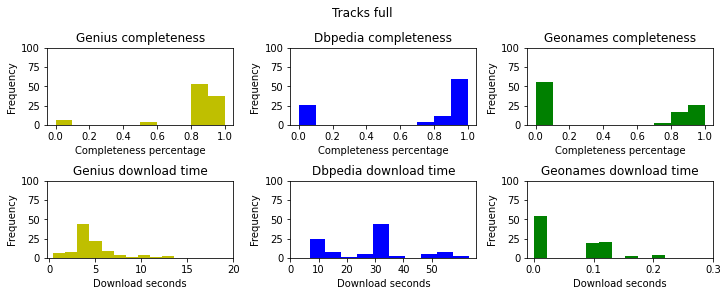

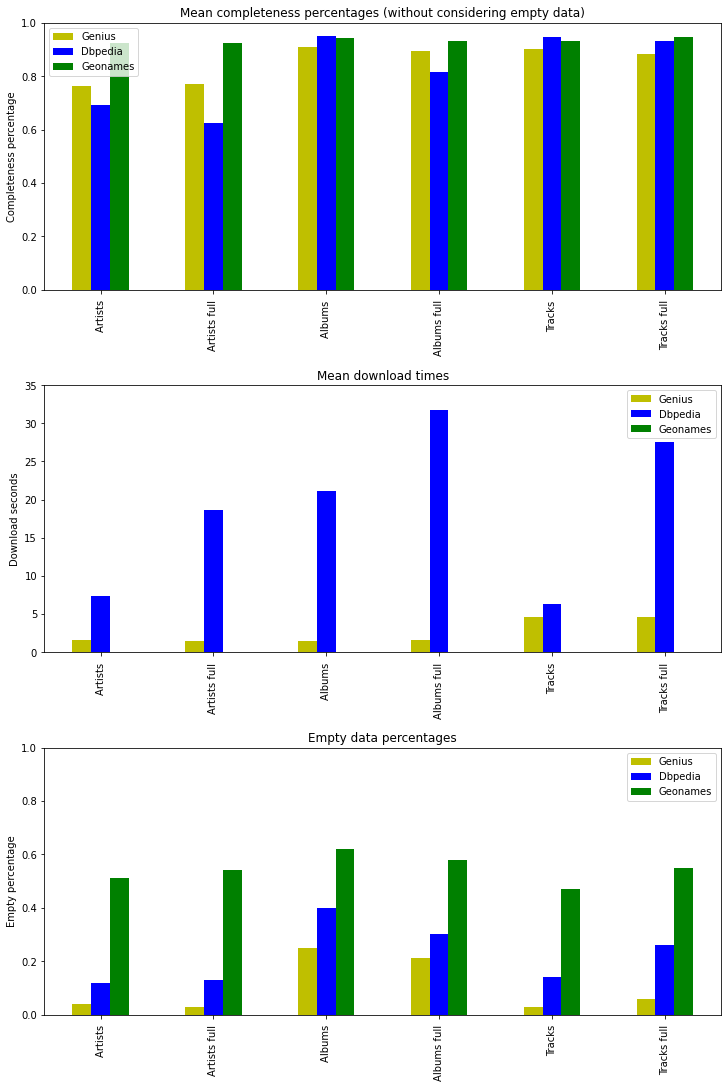

In [9]:
summary = pd.DataFrame()

for filename, dataframe in dataframes.items():
    genius_completeness = dataframe['genius_completeness']
    dbpedia_completeness = dataframe['dbpedia_completeness']
    geonames_completeness = dataframe['geonames_completeness']

    genius_download_time = dataframe['genius_download_time']
    dbpedia_download_time = dataframe['dbpedia_download_time']
    geonames_download_time = dataframe['geonames_download_time']

    # Plotting
    series_to_plot = [
                  genius_completeness, dbpedia_completeness, geonames_completeness,
                  genius_download_time, dbpedia_download_time, geonames_download_time
    ]
    plot_series(filename, series_to_plot)

    partial_summary = generate_partial_summary(filename, series_to_plot)
    summary = summary.append(partial_summary)

# Saving summary as Excel
dirname = 'plots/summary'
if os.path.exists(dirname) == False:
    os.mkdir(dirname)
filename = "summary.xlsx"
save_excel(summary, dirname, filename)

# Plotting summary
plot_summary(summary)

## 2.3 Download the completed analysis

In [10]:
!zip -r /content/plots.zip /content/plots/

  adding: content/plots/ (stored 0%)
  adding: content/plots/Tracks .png (deflated 11%)
  adding: content/plots/Albums .png (deflated 11%)
  adding: content/plots/Artists full .png (deflated 11%)
  adding: content/plots/Albums full .png (deflated 11%)
  adding: content/plots/Tracks full .png (deflated 11%)
  adding: content/plots/Artists .png (deflated 11%)
  adding: content/plots/summary/ (stored 0%)
  adding: content/plots/summary/summary.xlsx (deflated 10%)
  adding: content/plots/summary/summary_empty_data.png (deflated 17%)
  adding: content/plots/summary/summary_mean_completeness.png (deflated 17%)
  adding: content/plots/summary/summary_plots.png (deflated 17%)
  adding: content/plots/summary/summary_mean_download_time.png (deflated 17%)


In [11]:
from google.colab import files
files.download("/content/plots.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>